In [1]:
import pandas as pd
import numpy as np

In [2]:
def custom_date_parser(x):
    # Remove the " IST" portion if present.
    x = x.replace(" IST", "")
    
    # If the string contains a fractional seconds part, process it.
    if '.' in x:
        date_part, frac_and_tz = x.split('.', 1)
        parts = frac_and_tz.split(' ', 1)
        frac = parts[0]
        tz = parts[1] if len(parts) > 1 else ""
        
        # Truncate fractional seconds to 9 digits (seconds)
        frac = frac[:9].ljust(9, '0')
        x = f"{date_part}.{frac} {tz}"
        date_format = "%Y-%m-%d %H:%M:%S.%f %z"
    else:
        date_format = "%Y-%m-%d %H:%M:%S"
    
    return pd.to_datetime(x, format=date_format)

# --- File Paths ---
depth_file = "depth20_10001.csv"
aggtrade_file = "aggTrade1.csv"

# --- STEP 1: Load Data as strings (without automatic date parsing) ---
depth_df = pd.read_csv(depth_file)  # Time will be read as string
agg_df = pd.read_csv(aggtrade_file)


In [3]:
# --- STEP 2: Manually parse the Time column using our custom_date_parser ---
depth_df['Time'] = depth_df['Time'].apply(custom_date_parser)
agg_df['Time'] = agg_df['Time'].apply(custom_date_parser)

# Sort both dataframes by Time.
depth_df = depth_df.sort_values("Time").reset_index(drop=True)
agg_df = agg_df.sort_values("Time").reset_index(drop=True)

print(depth_df)
print(agg_df)

                                     Time  BidPriceL20  BidQtyL20  \
0     2025-03-14 00:00:02.292522546+05:30       579.20      0.621   
1     2025-03-14 00:00:03.292828523+05:30       579.08      2.612   
2     2025-03-14 00:00:04.292889586+05:30       579.14      1.948   
3     2025-03-14 00:00:05.292551566+05:30       579.07      0.013   
4     2025-03-14 00:00:06.292725093+05:30       579.11      9.143   
...                                   ...          ...        ...   
85350 2025-03-14 23:59:54.292671488+05:30       585.49      3.508   
85351 2025-03-14 23:59:55.292427075+05:30       585.51      4.271   
85352 2025-03-14 23:59:56.292630843+05:30       585.50      3.422   
85353 2025-03-14 23:59:57.292942801+05:30       585.51      4.271   
85354 2025-03-14 23:59:58.292470760+05:30       585.51      4.271   

       BidPriceL19  BidQtyL19  BidPriceL18  BidQtyL18  BidPriceL17  BidQtyL17  \
0           579.24      0.015       579.25      0.009       579.26      0.013   
1        

In [4]:
# --- STEP 3: Align aggTrade events with the most recent order book snapshot ---
# Use merge_asof to merge the latest depth snapshot with each trade event.
merged = pd.merge_asof(agg_df, 
                       depth_df,
                       on="Time",
                       direction="backward",
                       suffixes=("", "_Depth"))

In [5]:
# --- STEP 4: Compute Features Based on the Merged Data ---
def label_aggressive_side(row):
    # Check for missing data in top-of-book prices
    if pd.isna(row.get('AskPriceL1')) or pd.isna(row.get('BidPriceL1')):
        return "Unknown"
    # Aggressive buy if trade executed at or above best ask; aggressive sell if at or below best bid.
    if row['Price'] >= row['AskPriceL1']:
        return "Buy"
    elif row['Price'] <= row['BidPriceL1']:
        return "Sell"
    else:
        return "Passive"

merged['AggressiveSide'] = merged.apply(label_aggressive_side, axis=1)

def compute_top_level_remaining(row):
    if row['AggressiveSide'] == "Buy":
        return row['AskQtyL1'] - row['Quantity']
    elif row['AggressiveSide'] == "Sell":
        return row['BidQtyL1'] - row['Quantity']
    else:
        return np.nan

merged['TopLevelQtyRemaining'] = merged.apply(compute_top_level_remaining, axis=1)

# Additional feature: compute the bid-ask spread.
merged['Spread'] = merged['AskPriceL1'] - merged['BidPriceL1']

Merged data saved to merged_depth20_aggTrade.csv


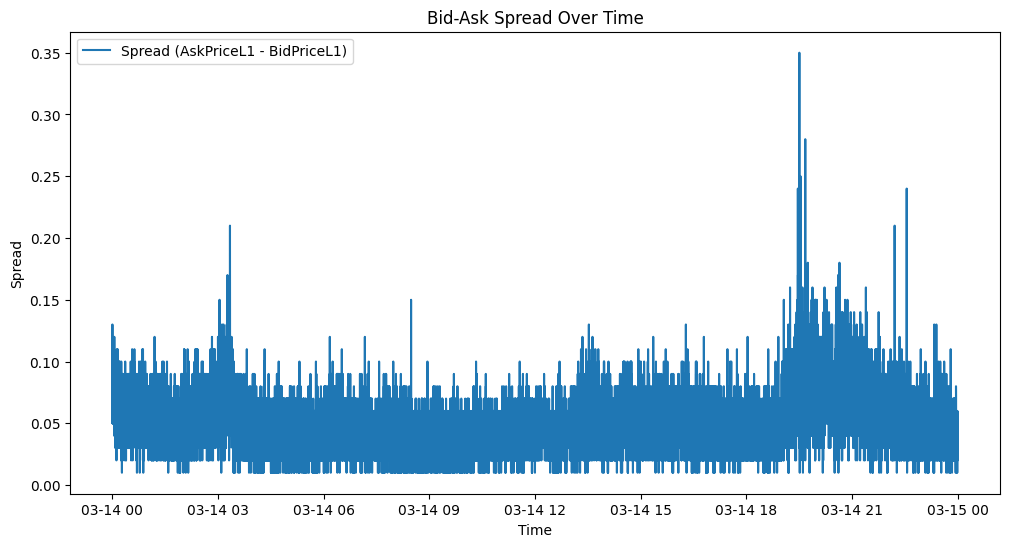

In [8]:
# --- STEP 5: Save the Merged Data for Further Analysis ---
merged.to_csv("merged_depth20_aggTrade.csv", index=False)
print("Merged data saved to merged_depth20_aggTrade.csv")

#Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
plt.plot(merged['Time'], merged['Spread'], label='Spread (AskPriceL1 - BidPriceL1)')
plt.xlabel("Time")
plt.ylabel("Spread")
plt.title("Bid-Ask Spread Over Time")
plt.legend()
plt.show()

# # Aggregated counts of trade types over time (per minute)
# agg_counts = merged.set_index('Time').resample('1min')['AggressiveSide'].value_counts().unstack().fillna(0)
# agg_counts.plot(figsize=(12, 6))
# plt.title("Trade Aggression Over Time (Counts per Minute)")
# plt.xlabel("Time")
# plt.ylabel("Count")
# plt.show()

In [9]:
print(merged.columns)
print(merged.head(1).T)
print(merged.index.name)  # If this prints 'Time', it’s your answer

merged.reset_index(inplace=True)
print(merged.columns.tolist())  # 'Time' should now appear

print(merged.columns.tolist())


Index(['index', 'Time', 'Price', 'Quantity', 'IsMarketMaker', 'NumTrades', 'M',
       'BidPriceL20', 'BidQtyL20', 'BidPriceL19', 'BidQtyL19', 'BidPriceL18',
       'BidQtyL18', 'BidPriceL17', 'BidQtyL17', 'BidPriceL16', 'BidQtyL16',
       'BidPriceL15', 'BidQtyL15', 'BidPriceL14', 'BidQtyL14', 'BidPriceL13',
       'BidQtyL13', 'BidPriceL12', 'BidQtyL12', 'BidPriceL11', 'BidQtyL11',
       'BidPriceL10', 'BidQtyL10', 'BidPriceL9', 'BidQtyL9', 'BidPriceL8',
       'BidQtyL8', 'BidPriceL7', 'BidQtyL7', 'BidPriceL6', 'BidQtyL6',
       'BidPriceL5', 'BidQtyL5', 'BidPriceL4', 'BidQtyL4', 'BidPriceL3',
       'BidQtyL3', 'BidPriceL2', 'BidQtyL2', 'BidPriceL1', 'BidQtyL1',
       'AskPriceL1', 'AskQtyL1', 'AskPriceL2', 'AskQtyL2', 'AskPriceL3',
       'AskQtyL3', 'AskPriceL4', 'AskQtyL4', 'AskPriceL5', 'AskQtyL5',
       'AskPriceL6', 'AskQtyL6', 'AskPriceL7', 'AskQtyL7', 'AskPriceL8',
       'AskQtyL8', 'AskPriceL9', 'AskQtyL9', 'AskPriceL10', 'AskQtyL10',
       'AskPriceL11', 'AskQtyL11

### 1. Feature Engineering

In [10]:
# Order book features:
# merged['spread'] = merged['AskPriceL1'] - merged['BidPriceL1']
merged['imbalance_lvl1'] = (merged['BidQtyL1'] - merged['AskQtyL1']) / (merged['BidQtyL1'] + merged['AskQtyL1'])
merged['microprice'] = (merged['BidPriceL1']*merged['AskQtyL1'] + merged['AskPriceL1']*merged['BidQtyL1']) / (merged['BidQtyL1'] + merged['AskQtyL1'])

# Cumulative depth:
bid_qty_cols = [f'BidQtyL{i}' for i in range(1, 21)]
ask_qty_cols = [f'AskQtyL{i}' for i in range(1, 21)]
merged['cum_bid_qty'] = merged[bid_qty_cols].sum(axis=1)
merged['cum_ask_qty'] = merged[ask_qty_cols].sum(axis=1)

# Derived example: Sloped depth (average gradient across levels)
bid_gradient = np.gradient(merged[bid_qty_cols], axis=1)
ask_gradient = np.gradient(merged[ask_qty_cols], axis=1)
merged['bid_slope'] = bid_gradient.mean(axis=1)
merged['ask_slope'] = ask_gradient.mean(axis=1)

# Make sure 'Time' is converted to datetime and set as the index
merged['Time'] = pd.to_datetime(merged['Time'])
merged = merged.sort_values('Time').set_index('Time')

#Compute the mid-price as the average of the best bid and best ask prices.
merged['mid_price'] = (merged['BidPriceL1'] + merged['AskPriceL1']) / 2
merged['log_return'] = np.log(merged['mid_price'] / merged['mid_price'].shift(1)) #Compute log returns of the mid-price.
merged['volatility_10s'] = merged['log_return'].rolling('10s').std() #Calculate rolling volatility (standard deviation of log returns)
merged['volatility_30s'] = merged['log_return'].rolling('30s').std()

merged['cum_volume_10s'] = merged['Quantity'].rolling('10s').sum() #Compute rolling cumulative volume if you have trade volume data in 'Quantity'
merged['cum_volume_30s'] = merged['Quantity'].rolling('30s').sum()


print(merged[['Spread','imbalance_lvl1','microprice','cum_bid_qty','cum_ask_qty','bid_slope','ask_slope', 'mid_price', 'log_return', 'volatility_10s', 'volatility_30s', 'cum_volume_10s', 'cum_volume_30s']].head())

                                     Spread  imbalance_lvl1  microprice  \
Time                                                                      
2025-03-14 00:00:02.764823793+05:30    0.08             0.0      579.48   
2025-03-14 00:00:02.781509697+05:30    0.08             0.0      579.48   
2025-03-14 00:00:02.805731800+05:30    0.08             0.0      579.48   
2025-03-14 00:00:03.902576812+05:30    0.08             0.0      579.40   
2025-03-14 00:00:03.905083833+05:30    0.08             0.0      579.40   

                                     cum_bid_qty  cum_ask_qty  bid_slope  \
Time                                                                       
2025-03-14 00:00:02.764823793+05:30       57.149       29.514  -0.008575   
2025-03-14 00:00:02.781509697+05:30       57.149       29.514  -0.008575   
2025-03-14 00:00:02.805731800+05:30       57.149       29.514  -0.008575   
2025-03-14 00:00:03.902576812+05:30       88.726       30.428   0.022525   
2025-03-14 00:00:0

In [11]:
print(merged['Spread'])


Time
2025-03-14 00:00:02.764823793+05:30    0.08
2025-03-14 00:00:02.781509697+05:30    0.08
2025-03-14 00:00:02.805731800+05:30    0.08
2025-03-14 00:00:03.902576812+05:30    0.08
2025-03-14 00:00:03.905083833+05:30    0.08
                                       ... 
2025-03-14 23:59:52.200441504+05:30    0.05
2025-03-14 23:59:55.813364295+05:30    0.03
2025-03-14 23:59:57.074433214+05:30    0.04
2025-03-14 23:59:58.719346954+05:30    0.03
2025-03-14 23:59:59.952502896+05:30    0.03
Name: Spread, Length: 302340, dtype: float64


### 2. Data Normalization

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Select feature columns for clustering
features = merged[['Spread', 'imbalance_lvl1', 'microprice', 'cum_bid_qty', 'cum_ask_qty', 'bid_slope', 'ask_slope']]
scaler = StandardScaler()  #z-score normalization
features_scaled = scaler.fit_transform(features)

# Optionally, reduce dimensionality to 3-5 principal components:
pca = PCA(n_components=5)
features_pca = pca.fit_transform(features_scaled)


# Subsample for silhouette score (e.g., 10k samples)
np.random.seed(42)
subsample_idx = np.random.choice(len(features_pca), size=min(10000, len(features_pca)), replace=False)
sample_data = features_pca[subsample_idx]

# You can inspect the transformed features:
print("Mean of each feature (should be close to 0):", features_scaled.mean(axis=0))
print("Standard Deviation (should be 1):", features_scaled.std(axis=0))

Mean of each feature (should be close to 0): [ 2.10572961e-17  0.00000000e+00  2.63035711e-14 -4.20393876e-16
 -3.33908553e-16 -4.17385691e-17  4.06104997e-17]
Standard Deviation (should be 1): [1. 1. 1. 1. 1. 1. 1.]


### 3. Clustering

In [ ]:
# #KMeans
# from sklearn.cluster import KMeans
# from sklearn.metrics import silhouette_score
# from sklearn.cluster import MiniBatchKMeans

# inertia = []
# silhouette = []
# K_range = range(2, 10)
# for k in K_range:
#     km = MiniBatchKMeans(n_clusters=k, batch_size=1000, random_state=42)
#     km.fit(sample_data)
#     inertia.append(km.inertia_)
#     silhouette.append(silhouette_score(sample_data, km.labels_))

# best_k = K_range[silhouette.index(max(silhouette))]

# # Final model on full PCA-transformed data
# final_km = MiniBatchKMeans(n_clusters=best_k, batch_size=1000, random_state=42)
# clusters = final_km.fit_predict(features_pca)
# merged['Regime_KMeans'] = clusters



# ####k-means
# ##Volatile(0) and stable(1)

# regime_summary = merged.groupby('Regime_KMeans').agg({
#     'Spread': ['mean', 'std'],
#     'imbalance_lvl1': 'mean',
#     'cum_bid_qty': 'mean',
#     'cum_ask_qty': 'mean'
# })
# print(regime_summary)

# import matplotlib.pyplot as plt
# import seaborn as sns

# # Calculate average spread
# avg_spread = merged['Spread'].mean()
# std_spread = merged['Spread'].std()

# # Count regimes based on spread compared to average
# above_avg = merged[merged['Spread'] > avg_spread]['Regime_KMeans'].value_counts()
# below_avg = merged[merged['Spread'] <= avg_spread]['Regime_KMeans'].value_counts()
# avg_std_above  = merged[merged['Spread'] > avg_spread + std_spread]['Regime_KMeans'].value_counts()

# print("Counts of regimes where Spread > avg:")
# print(above_avg)
# print("\nCounts of regimes where Spread <= avg:")
# print(below_avg)
# print("\navg_std:")
# print(avg_std_above)

# # Plot
# plt.figure(figsize=(12, 6))
# plt.plot(merged['Time'], merged['Spread'], label='Spread')
# plt.scatter(merged['Time'], merged['Regime_KMeans'], c='black', alpha=0.6, label='Regime')

# plt.axhline(avg_spread, color='red', linestyle='--', linewidth=1.5, label=f'Average Spread = {avg_spread:.4f}')
# plt.axhline(avg_spread + std_spread, color='orange', linestyle='--', linewidth=1.5, label=f'Avg + Std = {(avg_spread + std_spread):.4f}')

# plt.xlabel('Time')
# plt.ylabel('Spread / Regime')
# plt.title('Market Regime Evolution Over Time with Average Spread')
# plt.legend()
# plt.show()


In [ ]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
import hdbscan
import plotly.graph_objects as go

# 1. Extract Spread data from your `merged` DataFrame
spread_df = merged[['Spread']].copy().head(10000)
spread_df.columns.name = 'Spread'  # Set the column name for reference


######################################### Prepare data: moving average + log return #################################
def prepare_data_for_model_input(prices, ma):
    instrument = prices.columns.name if prices.columns.name else prices.columns[0]

    prices[f'{instrument}_ma'] = prices.rolling(ma).mean()
    prices[f'{instrument}_log_return'] = np.log(prices[f'{instrument}_ma'] / prices[f'{instrument}_ma'].shift(1))

    prices.dropna(inplace=True)
    prices_array = prices[[f'{instrument}_log_return']].values  # shape: (N, 1)
    
    return prices, prices_array

prices, prices_array = prepare_data_for_model_input(spread_df, ma=7)


###################################### Clustering class ##########################################
class RegimeDetection:
    def get_regimes_clustering(self, params):
        model = self.initialise_model(AgglomerativeClustering(), params)
        return model
    
    def get_regimes_gmm(self, input_data, params):
        model = self.initialise_model(GaussianMixture(), params)
        model.fit(input_data)
        return model
    
    def get_regimes_hdbscan(self, input_data, params):
        model = self.initialise_model(hdbscan.HDBSCAN(), params)
        model.fit(input_data)
        return model

    def initialise_model(self, model, params):
        for param, value in params.items():
            setattr(model, param, value)
        return model

################################################# Plotting function #####################################################
def plot_hidden_states(hidden_states, prices_df):
    colors = ['blue', 'green', 'red', 'orange', 'purple']
    n_components = len(np.unique(hidden_states))
    fig = go.Figure()

    for i in range(n_components):
        mask = hidden_states == i
        print('Number of observations for State', i, ":", mask.sum())
        
        fig.add_trace(go.Scatter(
            x=prices_df.index[mask],
            y=prices_df[f"{prices_df.columns.name}"][mask],
            mode='markers',
            name='Hidden State ' + str(i),
            marker=dict(size=4, color=colors[i % len(colors)])
        ))
    
    fig.update_layout(
        height=400, width=900,
        legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01),
        margin=dict(l=20, r=20, t=20, b=20)
    )
    fig.show()



def plot_hidden_states_for_HDBSCAN(hidden_states, prices_df):
    unique_states = np.unique(hidden_states)
    colors = ['blue', 'green', 'red', 'orange', 'purple', 'gray']
    fig = go.Figure()

    for i, state in enumerate(unique_states):
        mask = hidden_states == state
        label = f'Hidden State {state}' if state != -1 else 'Noise'

        print('Number of observations for', label, ":", mask.sum())
        
        fig.add_trace(go.Scatter(
            x=prices_df.index[mask],
            y=prices_df[f"{prices_df.columns.name}"][mask],
            mode='markers',
            name=label,
            marker=dict(size=4, color=colors[i % len(colors)])
        ))
    
    fig.update_layout(
        height=400, width=900,
        legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01),
        margin=dict(l=20, r=20, t=20, b=20)
    )
    fig.show()




########################################### AgglomerativeClustering ##########################################
#State 0	Quiet / Range-bound
#State 1	Volatile / Trending
params = {
    'n_clusters': 2,
    'linkage': 'complete',
    'metric': 'manhattan'  # Use 'metric', NOT 'affinity'
}
regime_detection = RegimeDetection()
clustering_model = regime_detection.get_regimes_clustering(params)
clustering_states = clustering_model.fit_predict(prices_array)
plot_hidden_states(clustering_states, prices[['Spread']])




#################### GMM regime detection ####################################################
params = {
    'n_components': 2,
    'covariance_type': 'full',
    'random_state': 42
}
regime_detection = RegimeDetection()
gmm_model = regime_detection.get_regimes_gmm(prices_array, params)
gmm_states = gmm_model.predict(prices_array)
plot_hidden_states(gmm_states, prices[['Spread']])



################################### HDBSCAN regime detection ###################################
params = {
    'min_cluster_size': 100,   # You can adjust this
    'min_samples': 10,         # Optional: controls how conservative it is
    'metric': 'manhattan'      # Good for financial time series
}
regime_detection = RegimeDetection()
hdbscan_model = regime_detection.get_regimes_hdbscan(prices_array, params)
hdbscan_states = hdbscan_model.labels_
plot_hidden_states_for_HDBSCAN(hdbscan_states, prices[['Spread']])


# 0	 Stable/sideways regime	          Low volatility, low return variation
# 1	 High volatility/mean-reverting	  Large swings but no clear direction
# 2	 Trending market(up/down)	      Log returns consistently positive or negative
#-1  Noise/anomaly/high uncertainty	  Outliers in spread return (maybe flash crash, data glitch, or non-clusterable patterns)

Number of observations for State 0 : 2813
Number of observations for State 1 : 7180


Number of observations for State 0 : 8584
Number of observations for State 1 : 1409


Number of observations for Noise : 37
Number of observations for Hidden State 0 : 2799
Number of observations for Hidden State 1 : 2857
Number of observations for Hidden State 2 : 351
Number of observations for Hidden State 3 : 3645
Number of observations for Hidden State 4 : 304


In [28]:

from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
import hdbscan
import plotly.graph_objects as go

# 1. Extract Spread data from your `merged` DataFrame
spread_df = merged[['Spread']].copy().head(10000)
spread_df.columns.name = 'Spread'  # For reference in plotting

# 2. Compute simple log return (no moving average)
spread_df['log_return'] = np.log(spread_df['Spread'] / spread_df['Spread'].shift(1))
spread_df.dropna(inplace=True)

# 3. Convert log returns to input array
prices_array = spread_df[['log_return']].values


###################################### Clustering Class ##########################################
class RegimeDetection:
    def get_regimes_clustering(self, params):
        model = self.initialise_model(AgglomerativeClustering(), params)
        return model
    
    def get_regimes_gmm(self, input_data, params):
        model = self.initialise_model(GaussianMixture(), params)
        model.fit(input_data)
        return model
    
    def get_regimes_hdbscan(self, input_data, params):
        model = self.initialise_model(hdbscan.HDBSCAN(), params)
        model.fit(input_data)
        return model

    def initialise_model(self, model, params):
        for param, value in params.items():
            setattr(model, param, value)
        return model


###################################### Plotting Functions ##########################################
def plot_hidden_states(hidden_states, prices_df):
    colors = ['blue', 'green', 'red', 'orange', 'purple']
    n_components = len(np.unique(hidden_states))
    fig = go.Figure()

    for i in range(n_components):
        mask = hidden_states == i
        print('Number of observations for State', i, ":", mask.sum())
        
        fig.add_trace(go.Scatter(
            x=prices_df.index[mask],
            y=prices_df[f"{prices_df.columns.name}"][mask],
            mode='markers',
            name='Hidden State ' + str(i),
            marker=dict(size=4, color=colors[i % len(colors)])
        ))
    
    fig.update_layout(
        height=400, width=900,
        legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01),
        margin=dict(l=20, r=20, t=20, b=20)
    )
    fig.show()


def plot_hidden_states_for_HDBSCAN(hidden_states, prices_df):
    unique_states = np.unique(hidden_states)
    colors = ['blue', 'green', 'red', 'orange', 'purple', 'gray']
    fig = go.Figure()

    for i, state in enumerate(unique_states):
        mask = hidden_states == state
        label = f'Hidden State {state}' if state != -1 else 'Noise'

        print('Number of observations for', label, ":", mask.sum())
        
        fig.add_trace(go.Scatter(
            x=prices_df.index[mask],
            y=prices_df[f"{prices_df.columns.name}"][mask],
            mode='markers',
            name=label,
            marker=dict(size=4, color=colors[i % len(colors)])
        ))
    
    fig.update_layout(
        height=400, width=900,
        legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01),
        margin=dict(l=20, r=20, t=20, b=20)
    )
    fig.show()


###################################### Run Regime Detection ##########################################

# Agglomerative Clustering
params = {
    'n_clusters': 2,
    'linkage': 'complete',
    'metric': 'manhattan'
}
regime_detection = RegimeDetection()
clustering_model = regime_detection.get_regimes_clustering(params)
clustering_states = clustering_model.fit_predict(prices_array)
plot_hidden_states(clustering_states, spread_df[['Spread']])

# Gaussian Mixture Model
params = {
    'n_components': 2,
    'covariance_type': 'full',
    'random_state': 42
}
gmm_model = regime_detection.get_regimes_gmm(prices_array, params)
gmm_states = gmm_model.predict(prices_array)
plot_hidden_states(gmm_states, spread_df[['Spread']])

# HDBSCAN
params = {
    'min_cluster_size': 100,
    'min_samples': 10,
    'metric': 'manhattan'
}
hdbscan_model = regime_detection.get_regimes_hdbscan(prices_array, params)
hdbscan_states = hdbscan_model.labels_
plot_hidden_states_for_HDBSCAN(hdbscan_states, spread_df[['Spread']])


Number of observations for State 0 : 9257
Number of observations for State 1 : 742


Number of observations for State 0 : 8511
Number of observations for State 1 : 1488


Number of observations for Noise : 283
Number of observations for Hidden State 0 : 180
Number of observations for Hidden State 1 : 102
Number of observations for Hidden State 2 : 8408
Number of observations for Hidden State 3 : 172
Number of observations for Hidden State 4 : 224
Number of observations for Hidden State 5 : 100
Number of observations for Hidden State 6 : 180
Number of observations for Hidden State 7 : 190
Number of observations for Hidden State 8 : 160


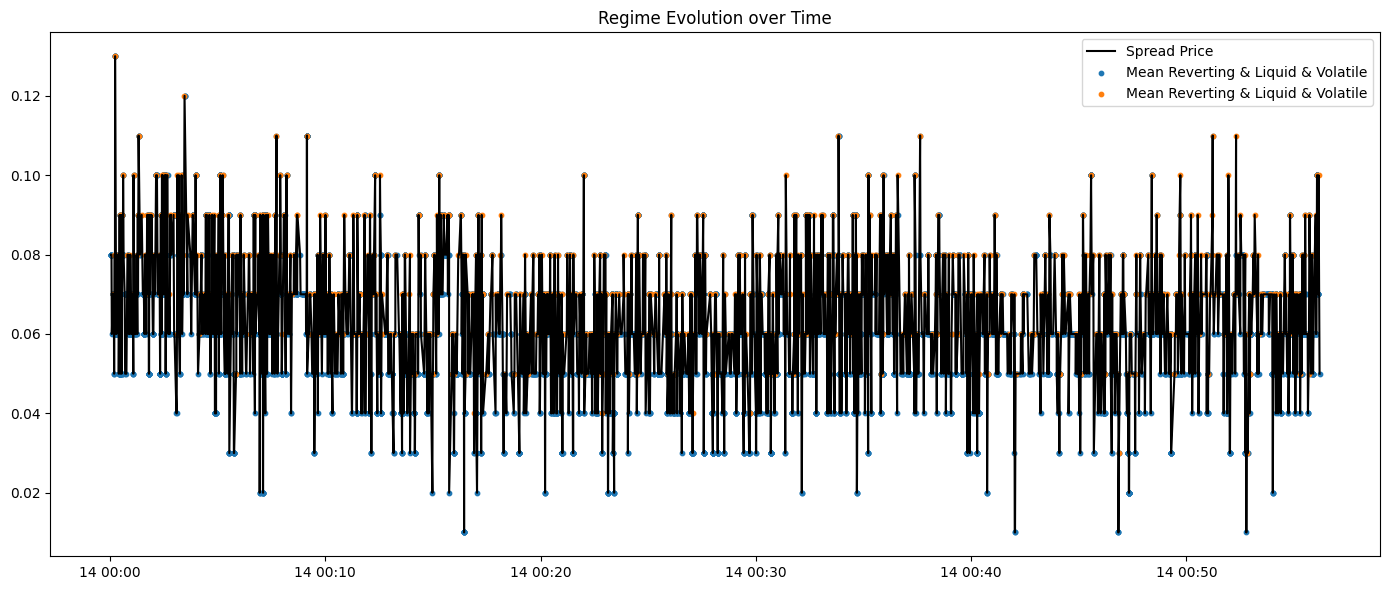

c:\Users\Mritunjay Maddhesiya\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



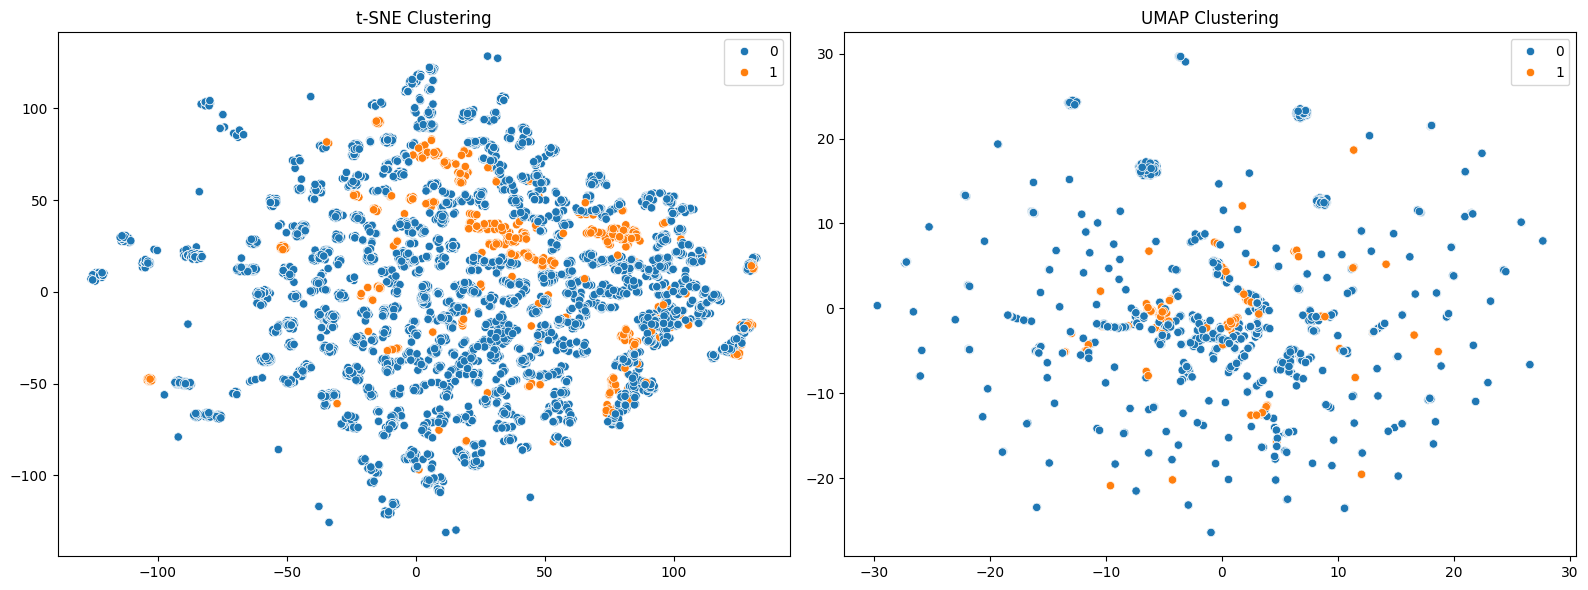


📊 Regime Descriptions:
    Regime                               Label
0       0  Mean Reverting & Liquid & Volatile
1       1  Mean Reverting & Liquid & Volatile

🔁 Regime Transition Matrix:
 To       0     1
From            
0     0.92  0.08
1     0.96  0.04


In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap

# 1. Calculate regime characteristics
def compute_regime_statistics(prices_df, hidden_states):
    regimes = np.unique(hidden_states)
    results = []

    for regime in regimes:
        mask = hidden_states == regime
        subset = prices_df[mask]

        avg_volatility = subset['Spread'].pct_change().rolling(10).std().mean()
        avg_spread = subset['Spread'].mean()
        liquidity_proxy = 1 / (subset['Spread'].rolling(5).std().mean() + 1e-6)
        price_direction = subset['Spread'].diff().mean()

        results.append({
            'Regime': regime,
            'Avg Volatility': avg_volatility,
            'Avg Spread': avg_spread,
            'Liquidity Proxy': liquidity_proxy,
            'Price Direction': price_direction
        })

    return pd.DataFrame(results)

# 2. Assign regime names based on characteristics
def label_regimes(stats_df):
    labels = []

    for _, row in stats_df.iterrows():
        vol = row['Avg Volatility']
        spread = row['Avg Spread']
        liq = row['Liquidity Proxy']
        direction = row['Price Direction']

        desc = ''
        if abs(direction) > 0.01:
            desc += 'Trending'
        else:
            desc += 'Mean Reverting'

        desc += ' & '

        if liq > 20:
            desc += 'Liquid'
        else:
            desc += 'Illiquid'

        desc += ' & '

        if vol < 0.005:
            desc += 'Stable'
        else:
            desc += 'Volatile'

        labels.append(desc)

    stats_df['Label'] = labels
    return stats_df

# 3. Plot regime vs time and price
def plot_regime_evolution(prices_df, hidden_states, regime_labels):
    fig, ax1 = plt.subplots(figsize=(14, 6))
    ax1.plot(prices_df.index, prices_df['Spread'], label='Spread Price', color='black')
    for regime in np.unique(hidden_states):
        ax1.scatter(prices_df.index[hidden_states == regime], 
                    prices_df['Spread'][hidden_states == regime], 
                    s=10, label=regime_labels[regime])

    ax1.set_title('Regime Evolution over Time')
    ax1.legend()
    plt.tight_layout()
    plt.show()

# 4. t-SNE / UMAP visualization with engineered features
def plot_tsne_umap(prices_df, hidden_states):
    features = pd.DataFrame({
        'Spread': prices_df['Spread'],
        'Volatility': prices_df['Spread'].pct_change().rolling(10).std(),
        'Price Change': prices_df['Spread'].diff(),
        'Rolling Spread Std': prices_df['Spread'].rolling(5).std()
    }).dropna()

    # Align hidden_states
    aligned_hidden_states = hidden_states[-len(features):]

    # PCA reduction before t-SNE/UMAP
    pca = PCA(n_components=min(10, features.shape[1])).fit_transform(features)

    # t-SNE
    tsne = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(pca)

    # UMAP
    reducer = umap.UMAP(random_state=42)
    umap_embedding = reducer.fit_transform(pca)

    # Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    sns.scatterplot(x=tsne[:, 0], y=tsne[:, 1], hue=aligned_hidden_states, palette='tab10', ax=ax1)
    ax1.set_title("t-SNE Clustering")
    sns.scatterplot(x=umap_embedding[:, 0], y=umap_embedding[:, 1], hue=aligned_hidden_states, palette='tab10', ax=ax2)
    ax2.set_title("UMAP Clustering")
    plt.tight_layout()
    plt.show()

# 5. Regime transition probabilities
def regime_transition_probabilities(hidden_states):
    transitions = pd.crosstab(pd.Series(hidden_states[:-1], name='From'),
                              pd.Series(hidden_states[1:], name='To'), normalize='index')
    return transitions.round(2)

# === Example Pipeline ===

# Assuming you already have:
# - prices_df with a 'Spread' column and datetime index
# - hidden_states from your clustering model (same length as prices_df)




# Run this after you have `prices_df` and `hidden_states`
prices_array = spread_df[['log_return']].values
# Define parameters for Agglomerative Clustering
params = {
    'n_clusters': 2,
    'linkage': 'complete',
    'metric': 'manhattan'
}
# Fit the model and get the hidden states
clustering_model = AgglomerativeClustering(**params)
hidden_states = clustering_model.fit_predict(prices_array)




stats_df = compute_regime_statistics(spread_df, hidden_states)
labeled_stats_df = label_regimes(stats_df)
regime_labels = dict(zip(labeled_stats_df['Regime'], labeled_stats_df['Label']))

plot_regime_evolution(spread_df, hidden_states, regime_labels)
plot_tsne_umap(spread_df, hidden_states)
transitions_df = regime_transition_probabilities(hidden_states)

print("\n📊 Regime Descriptions:\n", labeled_stats_df[['Regime', 'Label']])
print("\n🔁 Regime Transition Matrix:\n", transitions_df)


In [18]:
# probs = gmm_model.predict_proba(prices_array)
# print(probs[:5])  # See probabilities for first 5 points

# import matplotlib.pyplot as plt

# plt.hist(prices_array, bins=100)
# plt.title("Log Return Distribution")
# plt.xlabel("Log Return")
# plt.ylabel("Frequency")
# plt.show()


In [19]:
#HDBSCAN
#This method is non-parametric and can automatically detect noise:
# import hdbscan

# clusterer = hdbscan.HDBSCAN(min_cluster_size=50)
# hdbscan_labels = clusterer.fit_predict(features_pca)
# merged['Regime_HDBSCAN'] = hdbscan_labels


In [20]:
# #For soft-clustering(GMM)
# from sklearn.mixture import GaussianMixture

# gmm = GaussianMixture(n_components=best_k, random_state=42)
# gmm.fit(features_pca)
# gmm_labels = gmm.predict(features_pca)
# merged['Regime_GMM'] = gmm_labels 


In [21]:
# print(merged)

### 4. Regime Labeling and Analysis

In [34]:
# ##for HDBSCAN
# regime_summary = merged.groupby('Regime_HDBSCAN').agg({
#     'Spread': ['mean', 'std'],
#     'imbalance_lvl1': 'mean',
#     'cum_bid_qty': 'mean',
#     'cum_ask_qty': 'mean'
# })
# print(regime_summary)


# import matplotlib.pyplot as plt
# import seaborn as sns

# plt.figure(figsize=(12, 6))
# plt.plot(merged['Time'], merged['imbalance_lvl1'], label='imbalance_lvl1')
# plt.scatter(merged['Time'], merged['Regime_HDBSCAN'], c=merged['Regime_HDBSCAN'], cmap='tab10', alpha=0.6)
# plt.xlabel('Time')
# plt.ylabel('imbalance_lvl1')
# plt.title('Market Regime Evolution Over Time')
# plt.legend()
# plt.show()

In [33]:
# regime_summary3 = merged.groupby('Regime_GMM').agg({
#     'Spread': ['mean', 'std'],
#     'imbalance_lvl1': 'mean',
#     'cum_bid_qty': 'mean',
#     'cum_ask_qty': 'mean'
# })
# print(regime_summary3)

# import matplotlib.pyplot as plt
# import seaborn as sns

# plt.figure(figsize=(12, 6))
# plt.plot(merged['Time'], merged['Spread'], label='Spread')
# plt.scatter(merged['Time'], merged['Regime_GMM'], c=merged['Regime_GMM'], cmap='tab10', alpha=0.6)
# plt.xlabel('Time')
# plt.ylabel('Spread / Regime')
# plt.title('Market Regime Evolution Over Time')
# plt.legend()
# plt.show()

### 5. Visualization

In [22]:
# print(merged.columns)
# print(merged.head(1).T)
# print(merged.index.name)  # If this prints 'Time', it’s your answer

# #merged.reset_index(inplace=True)
# print(merged.columns.tolist())  # 'Time' should now appear
# print(merged)


In [30]:
# from sklearn.manifold import TSNE
# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np

# # Subsample if needed
# sample_n = 10000
# features_sample = features_pca[:sample_n]
# labels_sample = merged['Regime_KMeans'].values[:sample_n]

# # Clean if needed
# features_sample = np.nan_to_num(features_sample)

# # Fit t-SNE
# tsne = TSNE(n_components=2, random_state=42, perplexity=30)
# features_tsne = tsne.fit_transform(features_sample)

# # Plot
# plt.figure(figsize=(12, 6))
# sns.scatterplot(x=features_tsne[:,0], y=features_tsne[:,1], hue=labels_sample, palette='tab10')
# plt.title('t-SNE Visualization of Market Regimes')
# plt.show()



In [32]:
# #Regime Transition Insights:
# #Construct a transition matrix to study how regimes evolve from one timestamp to the next.
# transition_matrix = pd.crosstab(merged['Regime_KMeans'].shift(), merged['Regime_KMeans'], normalize='index')
# sns.heatmap(transition_matrix, annot=True, cmap="viridis")
# plt.title("Regime Transition Probabilities")
# plt.xlabel("Next Regime")
# plt.ylabel("Previous Regime")
# plt.show()
